<a href="https://colab.research.google.com/github/Zardian18/Cars_generation_different_models/blob/master/WGAN_GP_vs_PixelCNN_cars_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP Cars generation

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-23 06:32:23--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0s      

2024-01-23 06:32:23 (84.0 MB/s) - ‘helper.py’ saved [17171/17171]



In [ ]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [5]:
! kaggle datasets download -d markminerov/88500-car-images

100% 2.90G/2.91G [02:35<00:00, 20.5MB/s]
100% 2.91G/2.91G [02:35<00:00, 20.0MB/s]


In [ ]:
! unzip 88500-car-images.zip

In [7]:
train_data = utils.image_dataset_from_directory(
    "/content/out",
    labels= None,
    color_mode= "rgb",
    image_size=(32,32),
    batch_size=128,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 88560 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [8]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

train = train_data.map(lambda x: preprocess(x))

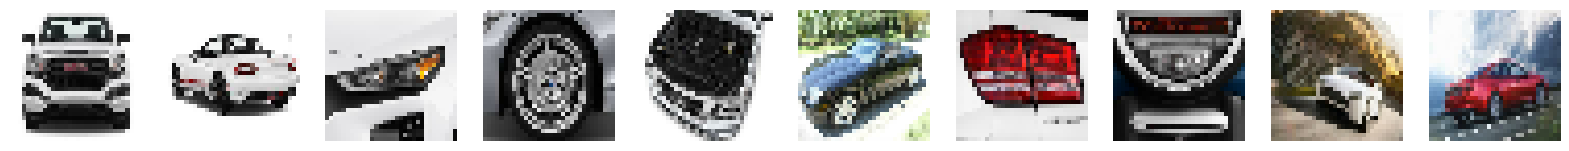

In [9]:
train_sample = sample_batch(train)
display(train_sample)

## Critic

In [10]:
critic_input = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(64, 5, strides=2, padding='same')(critic_input)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(512, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

critic_output = layers.Dense(1)(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 layer_normalization (Layer  (None, 8, 8, 128)         256       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                             

## Generator

In [11]:
generator_input = layers.Input(shape=(200,))

x = layers.Dense(4 * 4 * 256, use_bias=False)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Reshape((4, 4, 256))(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(3, (5, 5), strides=1, padding='same', activation='tanh', use_bias=False)(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              819200    
                                                                 
 batch_normalization (Batch  (None, 4096)              16384     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 256)         0         
 D)                                                        

In [12]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [13]:
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=200,
    critic_steps=3,
    gp_weight=10,
)

In [14]:
wgangp.compile(
    c_optimizer = optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5, beta_2 = 0.99),
    g_optimizer = optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.99),
)

In [15]:
class ImageGenerator_wgan(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
            cmap=None,
        )

In [16]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [17]:
! mkdir output/

Epoch 1/50
692/692 [==============================] - ETA: 0s - c_loss: -11.3444 - c_wass_loss: -14.2221 - c_gp: 0.2878 - g_loss: 9.2463
Saved to ./output/generated_img_000.png


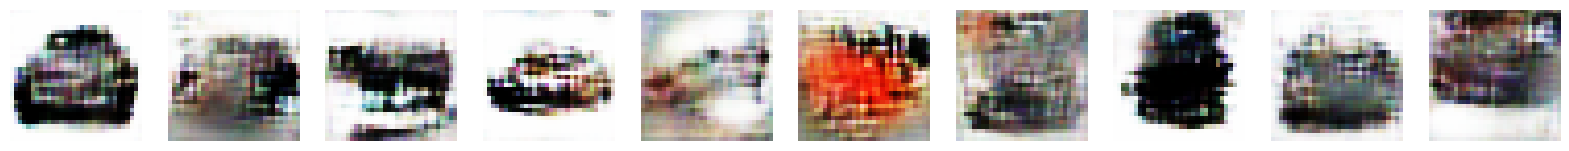

692/692 [==============================] - 287s 381ms/step - c_loss: -11.3444 - c_wass_loss: -14.2221 - c_gp: 0.2878 - g_loss: 9.2463
Epoch 2/50
692/692 [==============================] - ETA: 0s - c_loss: -10.8430 - c_wass_loss: -13.6405 - c_gp: 0.2798 - g_loss: 0.0907
Saved to ./output/generated_img_001.png


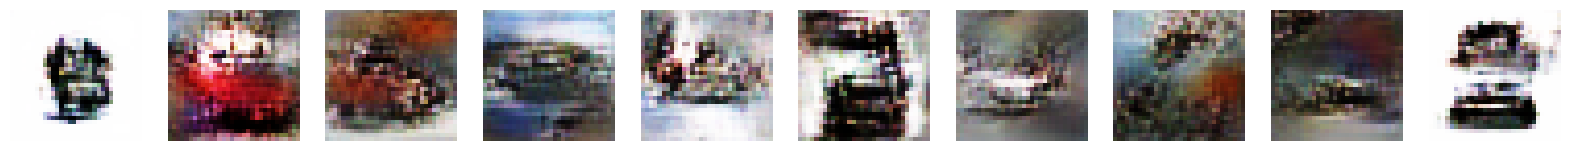

692/692 [==============================] - 265s 380ms/step - c_loss: -10.8430 - c_wass_loss: -13.6405 - c_gp: 0.2798 - g_loss: 0.0907
Epoch 3/50
692/692 [==============================] - ETA: 0s - c_loss: -9.7084 - c_wass_loss: -12.2566 - c_gp: 0.2548 - g_loss: 2.8064
Saved to ./output/generated_img_002.png


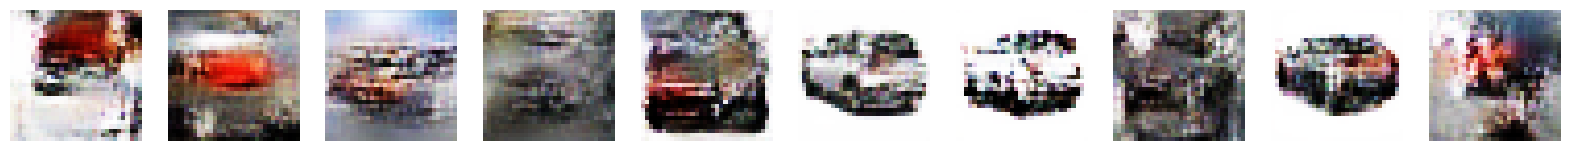

692/692 [==============================] - 264s 380ms/step - c_loss: -9.7084 - c_wass_loss: -12.2566 - c_gp: 0.2548 - g_loss: 2.8064
Epoch 4/50
692/692 [==============================] - ETA: 0s - c_loss: -9.0228 - c_wass_loss: -11.4242 - c_gp: 0.2401 - g_loss: 7.1951
Saved to ./output/generated_img_003.png


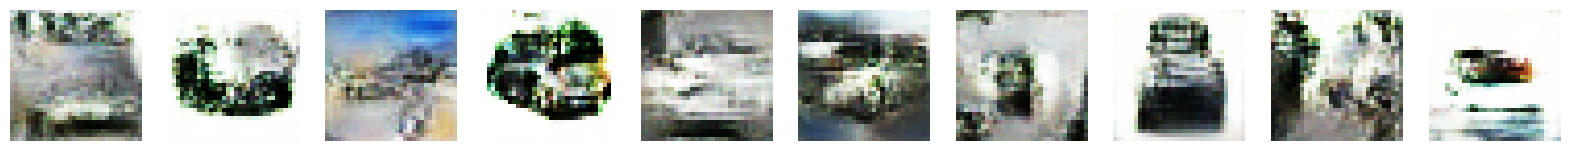

692/692 [==============================] - 264s 380ms/step - c_loss: -9.0228 - c_wass_loss: -11.4242 - c_gp: 0.2401 - g_loss: 7.1951
Epoch 5/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6591 - c_wass_loss: -10.8957 - c_gp: 0.2237 - g_loss: 9.9846
Saved to ./output/generated_img_004.png


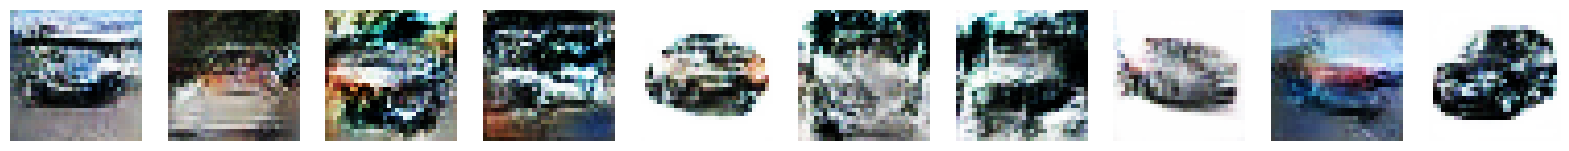

692/692 [==============================] - 264s 380ms/step - c_loss: -8.6591 - c_wass_loss: -10.8957 - c_gp: 0.2237 - g_loss: 9.9846
Epoch 6/50
692/692 [==============================] - ETA: 0s - c_loss: -8.4327 - c_wass_loss: -10.6375 - c_gp: 0.2205 - g_loss: 10.1765
Saved to ./output/generated_img_005.png


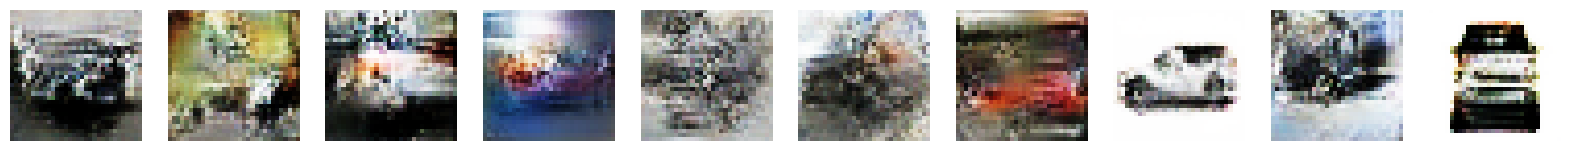

692/692 [==============================] - 265s 381ms/step - c_loss: -8.4327 - c_wass_loss: -10.6375 - c_gp: 0.2205 - g_loss: 10.1765
Epoch 7/50
692/692 [==============================] - ETA: 0s - c_loss: -8.3071 - c_wass_loss: -10.4974 - c_gp: 0.2190 - g_loss: 10.0285
Saved to ./output/generated_img_006.png


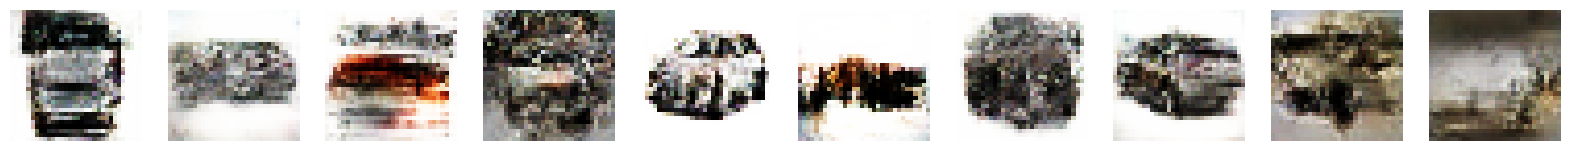

692/692 [==============================] - 266s 383ms/step - c_loss: -8.3071 - c_wass_loss: -10.4974 - c_gp: 0.2190 - g_loss: 10.0285
Epoch 8/50
692/692 [==============================] - ETA: 0s - c_loss: -8.3155 - c_wass_loss: -10.4560 - c_gp: 0.2141 - g_loss: 9.6117
Saved to ./output/generated_img_007.png


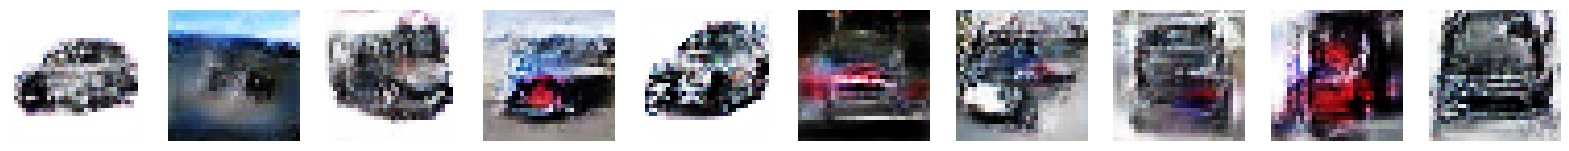

692/692 [==============================] - 264s 379ms/step - c_loss: -8.3155 - c_wass_loss: -10.4560 - c_gp: 0.2141 - g_loss: 9.6117
Epoch 9/50
692/692 [==============================] - ETA: 0s - c_loss: -8.3038 - c_wass_loss: -10.4819 - c_gp: 0.2178 - g_loss: 9.4485
Saved to ./output/generated_img_008.png


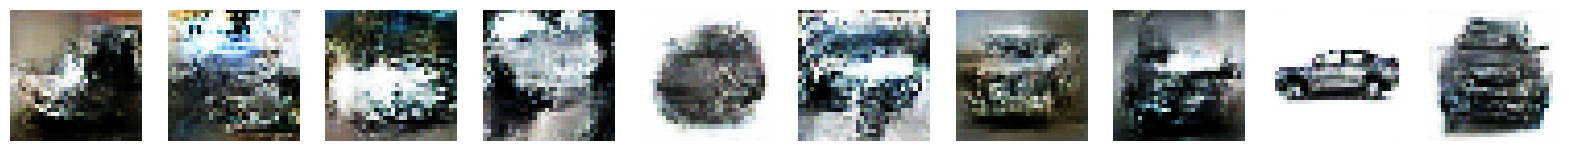

692/692 [==============================] - 264s 379ms/step - c_loss: -8.3038 - c_wass_loss: -10.4819 - c_gp: 0.2178 - g_loss: 9.4485
Epoch 10/50
692/692 [==============================] - ETA: 0s - c_loss: -8.3761 - c_wass_loss: -10.5351 - c_gp: 0.2159 - g_loss: 8.5926
Saved to ./output/generated_img_009.png


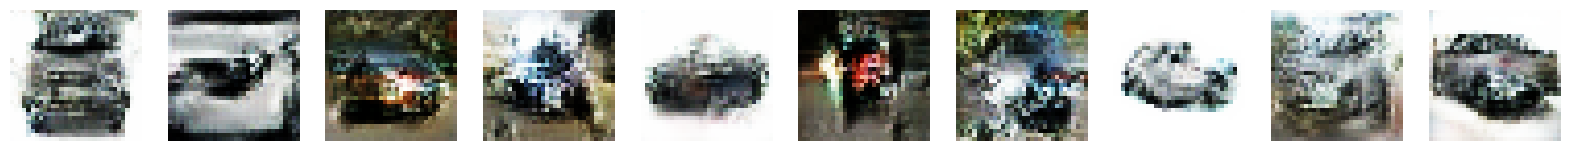

692/692 [==============================] - 265s 382ms/step - c_loss: -8.3761 - c_wass_loss: -10.5351 - c_gp: 0.2159 - g_loss: 8.5926
Epoch 11/50
692/692 [==============================] - ETA: 0s - c_loss: -8.4388 - c_wass_loss: -10.6245 - c_gp: 0.2186 - g_loss: 7.6224
Saved to ./output/generated_img_010.png


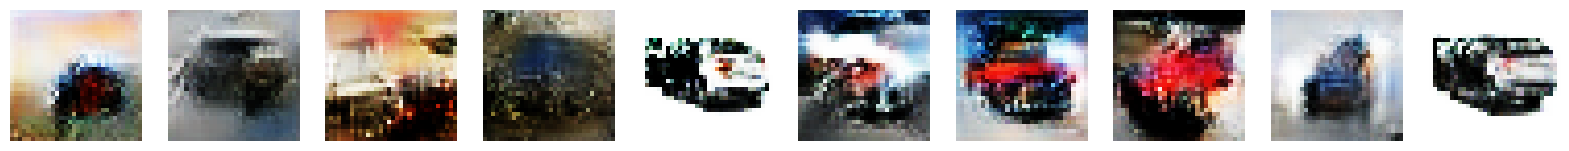

692/692 [==============================] - 265s 381ms/step - c_loss: -8.4388 - c_wass_loss: -10.6245 - c_gp: 0.2186 - g_loss: 7.6224
Epoch 12/50
692/692 [==============================] - ETA: 0s - c_loss: -8.4803 - c_wass_loss: -10.7002 - c_gp: 0.2220 - g_loss: 6.1207
Saved to ./output/generated_img_011.png


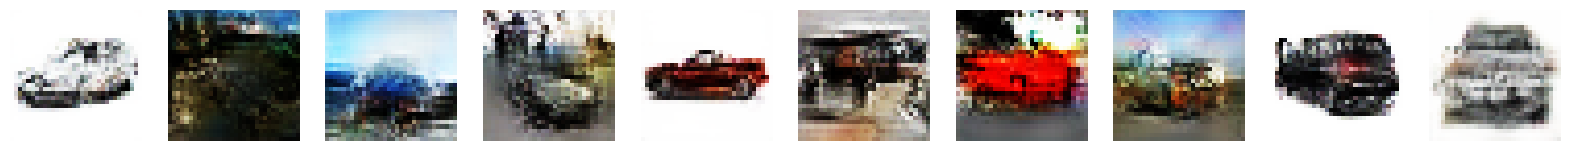

692/692 [==============================] - 265s 381ms/step - c_loss: -8.4803 - c_wass_loss: -10.7002 - c_gp: 0.2220 - g_loss: 6.1207
Epoch 13/50
692/692 [==============================] - ETA: 0s - c_loss: -8.5719 - c_wass_loss: -10.8556 - c_gp: 0.2284 - g_loss: 4.6740
Saved to ./output/generated_img_012.png


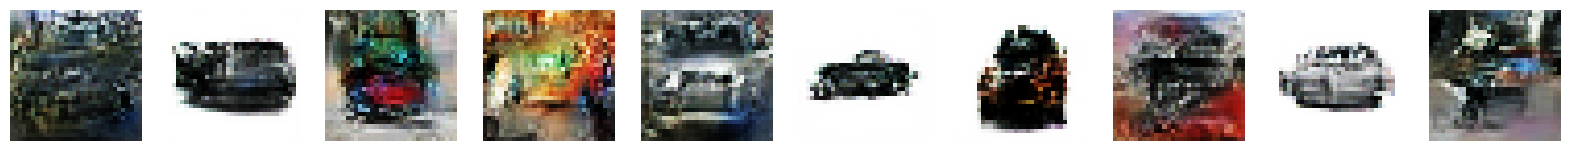

692/692 [==============================] - 266s 381ms/step - c_loss: -8.5719 - c_wass_loss: -10.8556 - c_gp: 0.2284 - g_loss: 4.6740
Epoch 14/50
692/692 [==============================] - ETA: 0s - c_loss: -8.5348 - c_wass_loss: -10.8510 - c_gp: 0.2316 - g_loss: 2.9752
Saved to ./output/generated_img_013.png


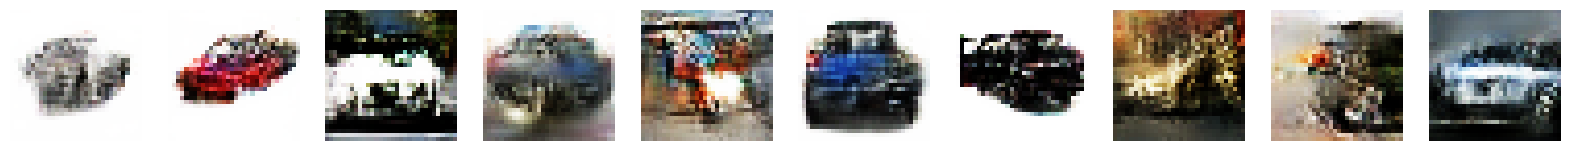

692/692 [==============================] - ETA: 0s - c_loss: -8.6133 - c_wass_loss: -10.8950 - c_gp: 0.2282 - g_loss: 0.8578
Saved to ./output/generated_img_014.png


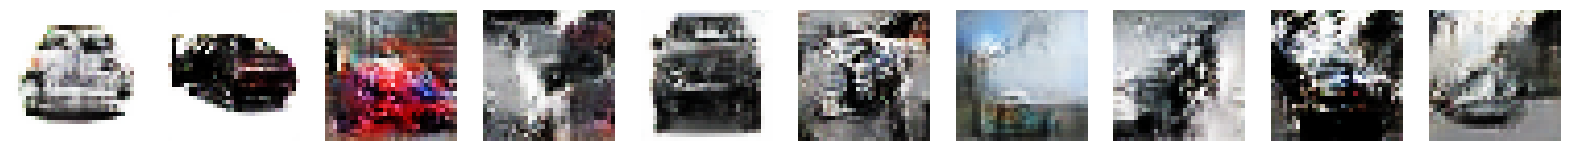

692/692 [==============================] - 265s 381ms/step - c_loss: -8.6133 - c_wass_loss: -10.8950 - c_gp: 0.2282 - g_loss: 0.8578
Epoch 16/50
692/692 [==============================] - ETA: 0s - c_loss: -8.5220 - c_wass_loss: -10.8673 - c_gp: 0.2345 - g_loss: -1.5954
Saved to ./output/generated_img_015.png


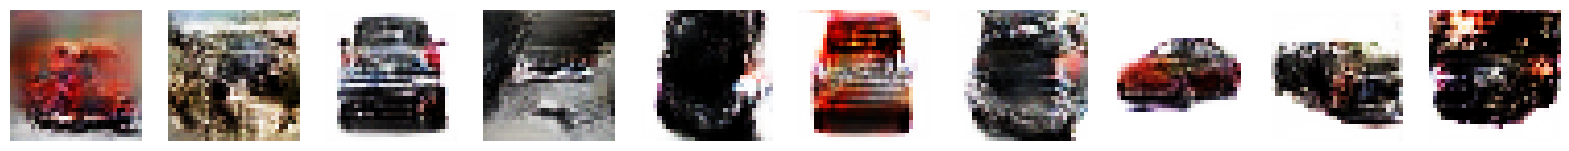

692/692 [==============================] - 265s 382ms/step - c_loss: -8.5220 - c_wass_loss: -10.8673 - c_gp: 0.2345 - g_loss: -1.5954
Epoch 17/50
692/692 [==============================] - ETA: 0s - c_loss: -8.5766 - c_wass_loss: -10.9071 - c_gp: 0.2330 - g_loss: -3.4087
Saved to ./output/generated_img_016.png


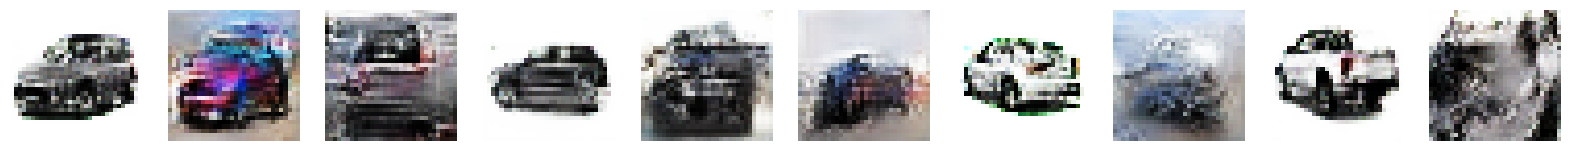

692/692 [==============================] - 265s 380ms/step - c_loss: -8.5766 - c_wass_loss: -10.9071 - c_gp: 0.2330 - g_loss: -3.4087
Epoch 18/50
692/692 [==============================] - ETA: 0s - c_loss: -8.5932 - c_wass_loss: -10.9110 - c_gp: 0.2318 - g_loss: -5.2596
Saved to ./output/generated_img_017.png


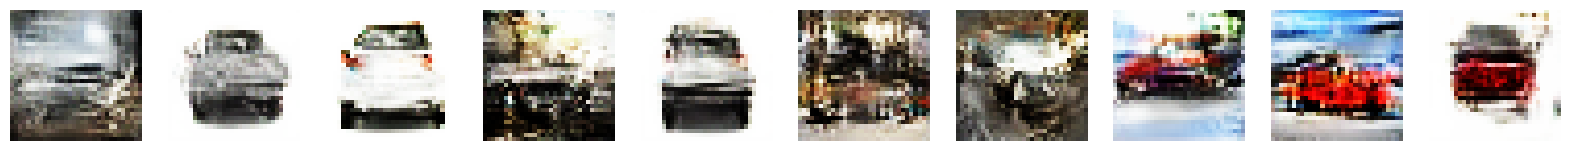

692/692 [==============================] - 264s 380ms/step - c_loss: -8.5932 - c_wass_loss: -10.9110 - c_gp: 0.2318 - g_loss: -5.2596
Epoch 19/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6171 - c_wass_loss: -10.9021 - c_gp: 0.2285 - g_loss: -7.4208
Saved to ./output/generated_img_018.png


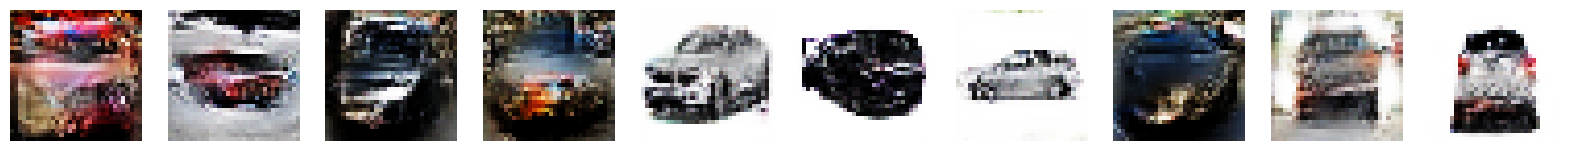

692/692 [==============================] - 265s 381ms/step - c_loss: -8.6171 - c_wass_loss: -10.9021 - c_gp: 0.2285 - g_loss: -7.4208
Epoch 20/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6590 - c_wass_loss: -10.9793 - c_gp: 0.2320 - g_loss: -9.1823
Saved to ./output/generated_img_019.png


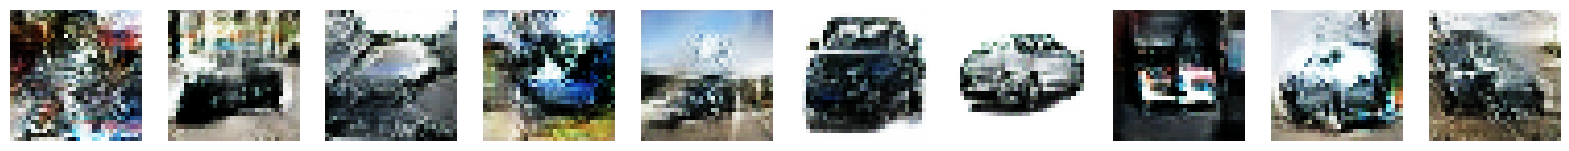

692/692 [==============================] - 266s 382ms/step - c_loss: -8.6590 - c_wass_loss: -10.9793 - c_gp: 0.2320 - g_loss: -9.1823
Epoch 21/50
692/692 [==============================] - ETA: 0s - c_loss: -8.5958 - c_wass_loss: -10.9516 - c_gp: 0.2356 - g_loss: -11.4590
Saved to ./output/generated_img_020.png


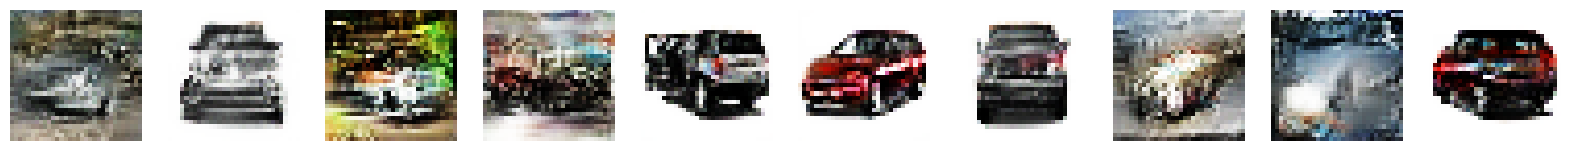

692/692 [==============================] - 265s 381ms/step - c_loss: -8.5958 - c_wass_loss: -10.9516 - c_gp: 0.2356 - g_loss: -11.4590
Epoch 22/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6274 - c_wass_loss: -11.0107 - c_gp: 0.2383 - g_loss: -13.6847
Saved to ./output/generated_img_021.png


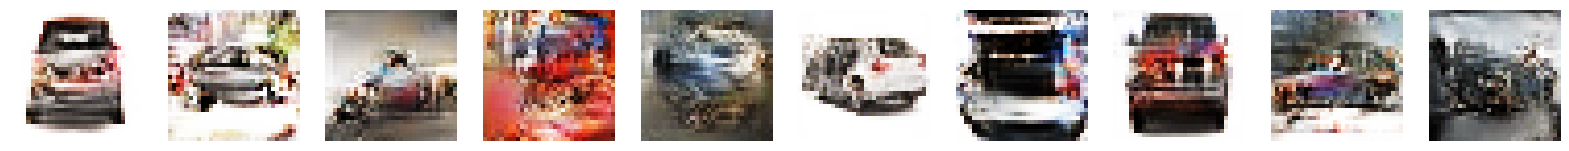

692/692 [==============================] - 265s 381ms/step - c_loss: -8.6274 - c_wass_loss: -11.0107 - c_gp: 0.2383 - g_loss: -13.6847
Epoch 23/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6347 - c_wass_loss: -11.0149 - c_gp: 0.2380 - g_loss: -15.8216
Saved to ./output/generated_img_022.png


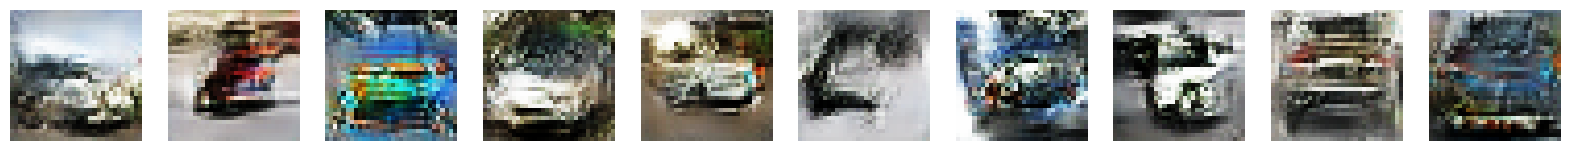

692/692 [==============================] - 265s 381ms/step - c_loss: -8.6347 - c_wass_loss: -11.0149 - c_gp: 0.2380 - g_loss: -15.8216
Epoch 24/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6197 - c_wass_loss: -11.0085 - c_gp: 0.2389 - g_loss: -17.7689
Saved to ./output/generated_img_023.png


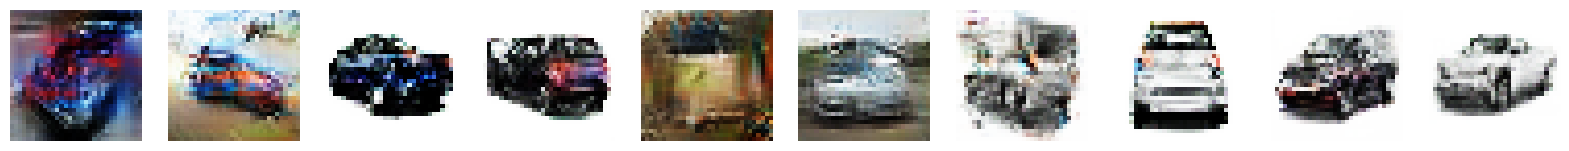

692/692 [==============================] - 265s 382ms/step - c_loss: -8.6197 - c_wass_loss: -11.0085 - c_gp: 0.2389 - g_loss: -17.7689
Epoch 25/50
692/692 [==============================] - ETA: 0s - c_loss: -8.6346 - c_wass_loss: -11.0240 - c_gp: 0.2389 - g_loss: -19.7321
Saved to ./output/generated_img_024.png


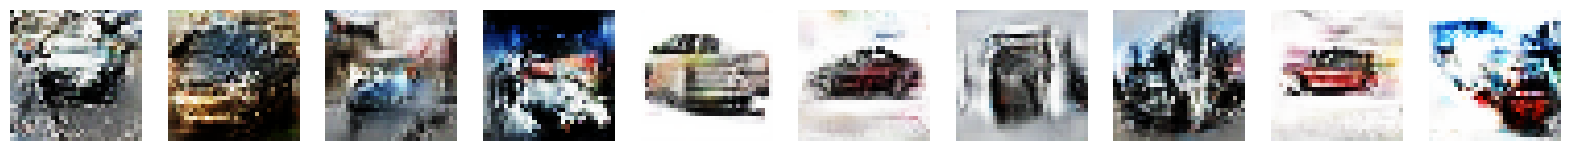

692/692 [==============================] - 265s 381ms/step - c_loss: -8.6346 - c_wass_loss: -11.0240 - c_gp: 0.2389 - g_loss: -19.7321


KeyboardInterrupt: 

In [18]:
wgangp.fit(
    train,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator_wgan(num_img=10, latent_dim=200),
    ],
)

## Image Generation

1/1 [==============================] - 0s 34ms/step


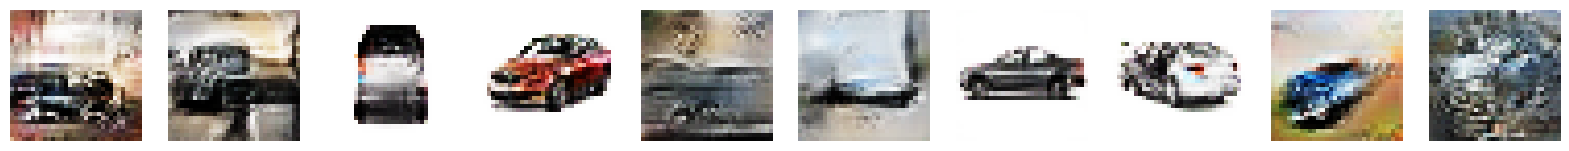

In [29]:
z_sample = np.random.normal(size=(10, 200))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

# PixelCNN

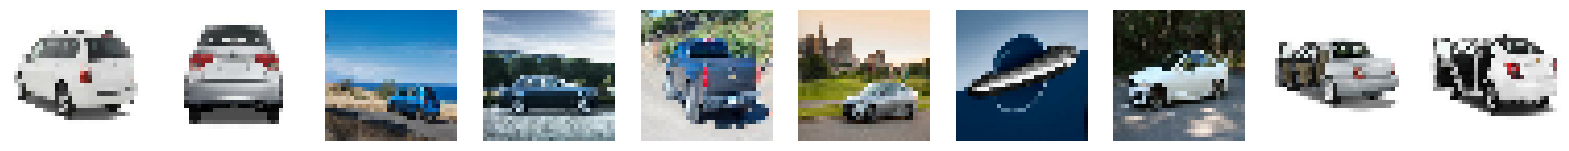

In [20]:
display(sample_batch(train_data))

In [21]:
dist = tfp.distributions.PixelCNN(
    image_shape=(32,32,3),
    num_resnet = 2,
    num_hierarchies =3,
    num_filters = 32,
    num_logistic_mix = 10,
    dropout_p =0.5
)

image_input = layers.Input(shape=(32,32,3))
log_prob = dist.log_prob(image_input)

pixelcnn = models.Model(image_input, log_prob)
pixelcnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 tf.reshape_1 (TFOpLambda)   (None, 32, 32, 3)            0         ['input_4[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 32, 32, 3)            0         ['tf.reshape_1[0][0]']        
 da)                                                                                              
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 32, 32, 3)            0         ['tf.math.subtract[0][0]

In [22]:
pixelcnn.add_loss(-tf.reduce_mean(log_prob))
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [23]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output_pixelcnn/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=4)

In [24]:
! mkdir output_pixelcnn/

Layer _PixelCNNNetwork was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/25
  6/692 [..............................] - ETA: 4:53 - loss: 17010.8770

692/692 [==============================] - ETA: 0s - loss: 9976.7139
Saved to ./output_pixelcnn/generated_img_000.png


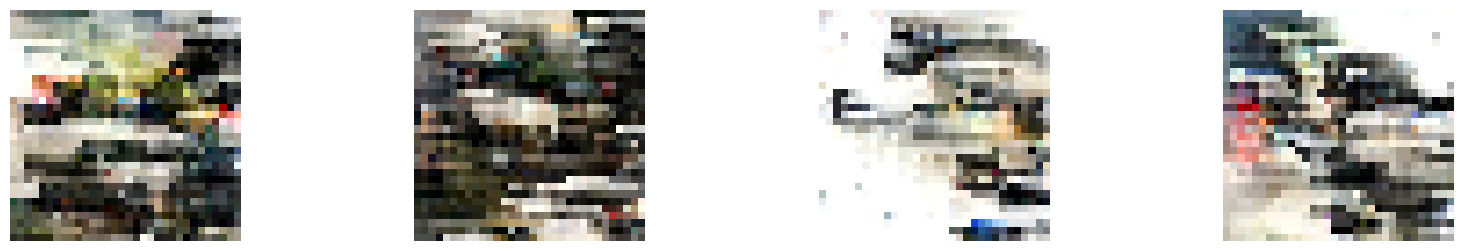

692/692 [==============================] - 655s 850ms/step - loss: 9976.7139
Epoch 2/25
692/692 [==============================] - ETA: 0s - loss: 8819.5293
Saved to ./output_pixelcnn/generated_img_001.png


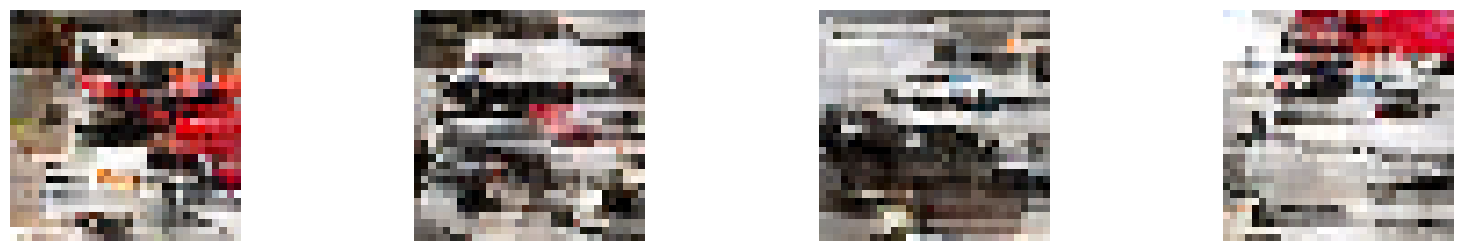

692/692 [==============================] - 589s 848ms/step - loss: 8819.5293
Epoch 3/25
692/692 [==============================] - ETA: 0s - loss: 8504.7607
Saved to ./output_pixelcnn/generated_img_002.png


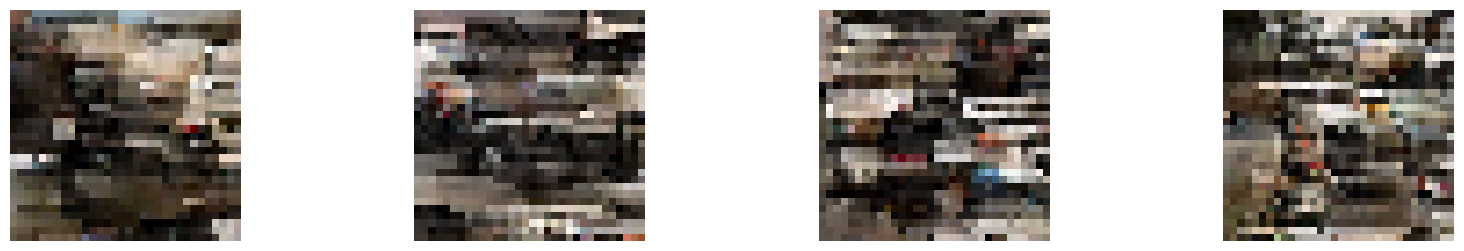

692/692 [==============================] - 587s 848ms/step - loss: 8504.7607
Epoch 4/25
692/692 [==============================] - ETA: 0s - loss: 8344.0234
Saved to ./output_pixelcnn/generated_img_003.png


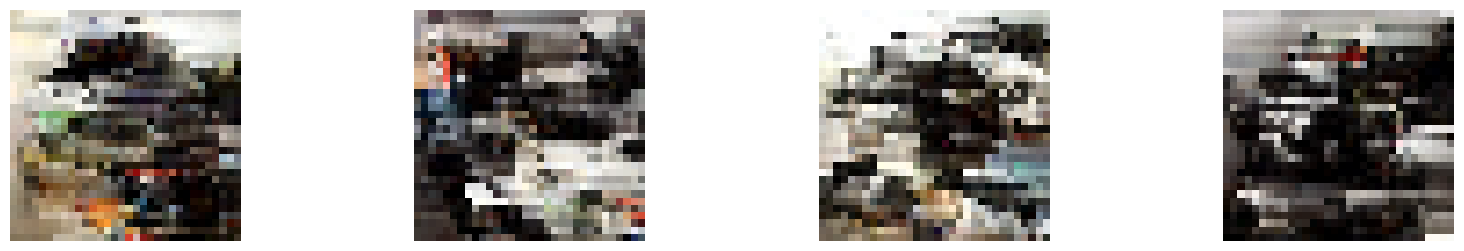

692/692 [==============================] - 587s 847ms/step - loss: 8344.0234
Epoch 5/25
692/692 [==============================] - ETA: 0s - loss: 8202.6445
Saved to ./output_pixelcnn/generated_img_004.png


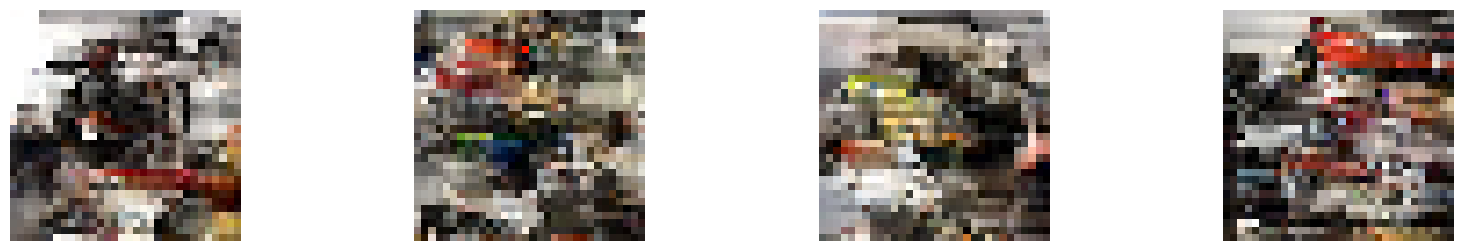

692/692 [==============================] - 586s 846ms/step - loss: 8202.6445
Epoch 6/25
692/692 [==============================] - ETA: 0s - loss: 8146.4189
Saved to ./output_pixelcnn/generated_img_005.png


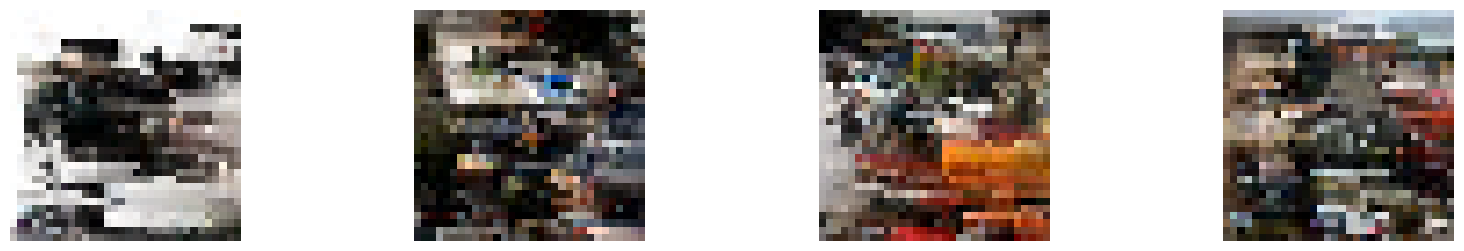

692/692 [==============================] - 586s 845ms/step - loss: 8146.4189
Epoch 7/25
692/692 [==============================] - ETA: 0s - loss: 7987.2271
Saved to ./output_pixelcnn/generated_img_006.png


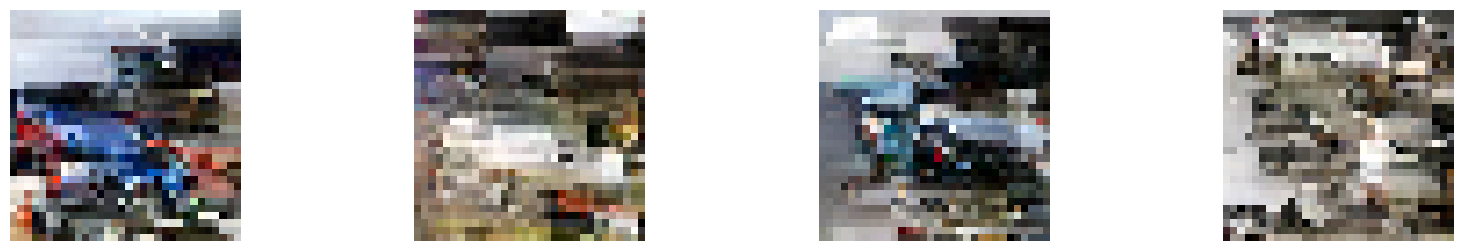

692/692 [==============================] - 587s 848ms/step - loss: 7987.2271
Epoch 8/25
692/692 [==============================] - ETA: 0s - loss: 7896.2544
Saved to ./output_pixelcnn/generated_img_007.png


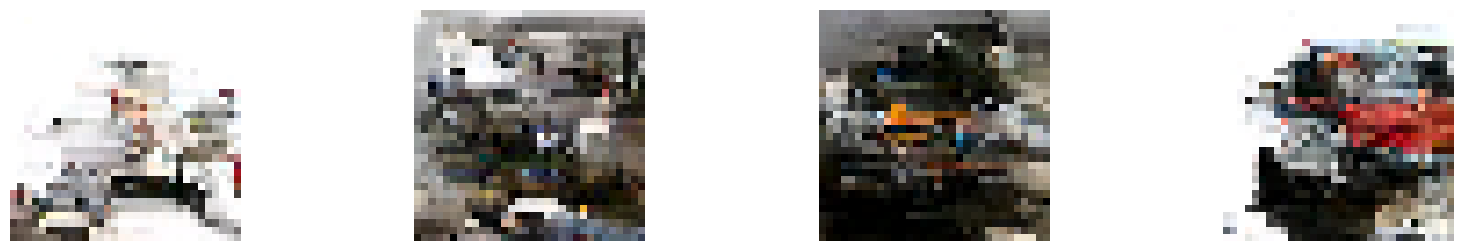

692/692 [==============================] - 598s 860ms/step - loss: 7896.2544
Epoch 9/25
692/692 [==============================] - ETA: 0s - loss: 7828.0938
Saved to ./output_pixelcnn/generated_img_008.png


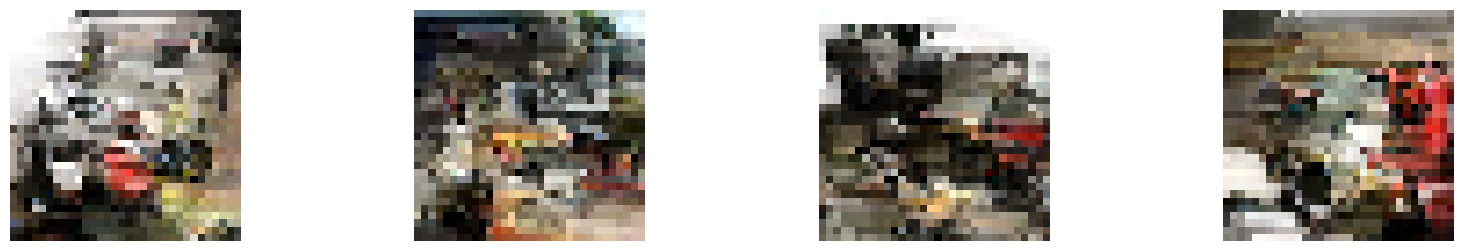

692/692 [==============================] - 582s 840ms/step - loss: 7828.0938
Epoch 10/25
692/692 [==============================] - ETA: 0s - loss: 7786.3838
Saved to ./output_pixelcnn/generated_img_009.png


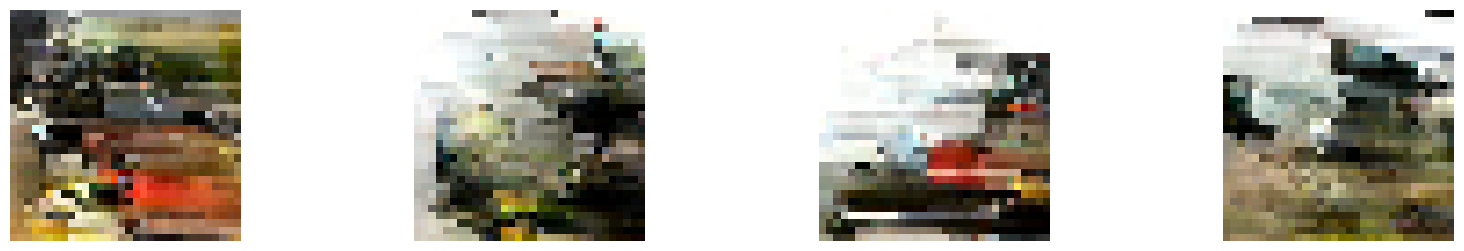

692/692 [==============================] - 582s 839ms/step - loss: 7786.3838
Epoch 11/25
692/692 [==============================] - ETA: 0s - loss: 7730.0469
Saved to ./output_pixelcnn/generated_img_010.png


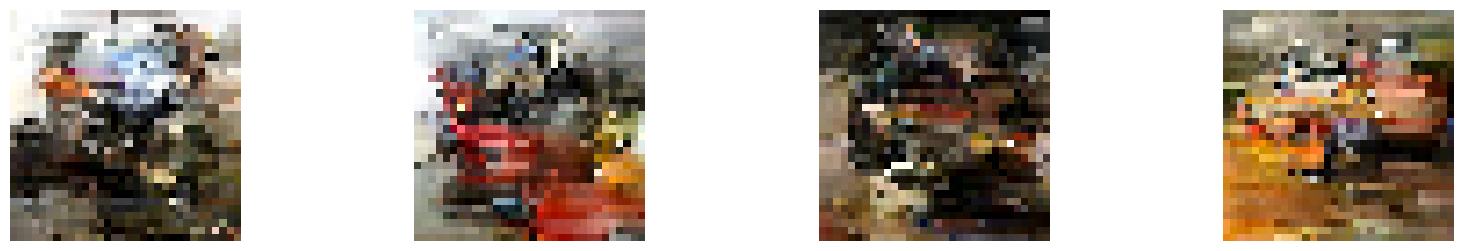

692/692 [==============================] - 589s 850ms/step - loss: 7730.0469
Epoch 12/25
692/692 [==============================] - ETA: 0s - loss: 7662.3447
Saved to ./output_pixelcnn/generated_img_011.png


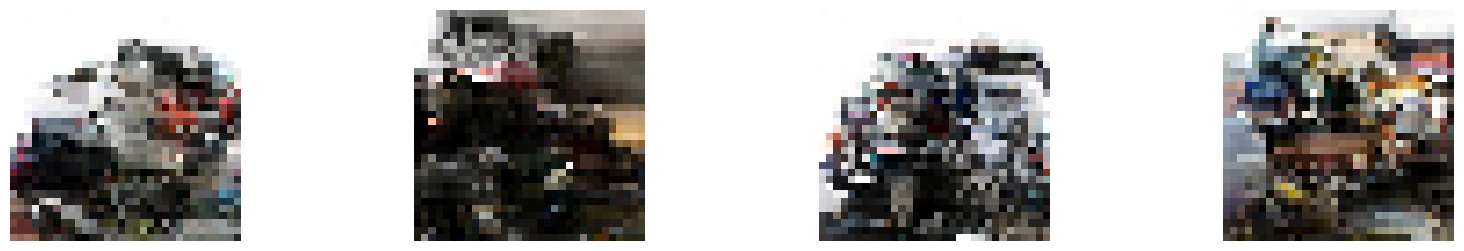

692/692 [==============================] - 578s 833ms/step - loss: 7662.3447
Epoch 13/25
692/692 [==============================] - ETA: 0s - loss: 7656.9478
Saved to ./output_pixelcnn/generated_img_012.png


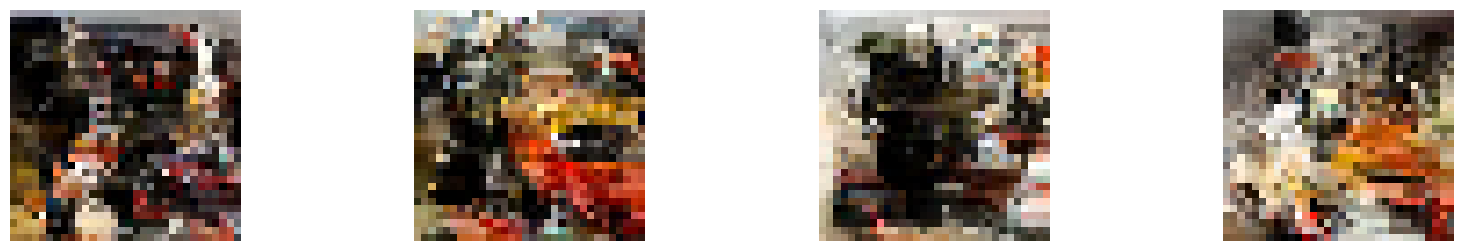

692/692 [==============================] - 574s 828ms/step - loss: 7656.9478
Epoch 14/25
692/692 [==============================] - ETA: 0s - loss: 7613.6313
Saved to ./output_pixelcnn/generated_img_013.png


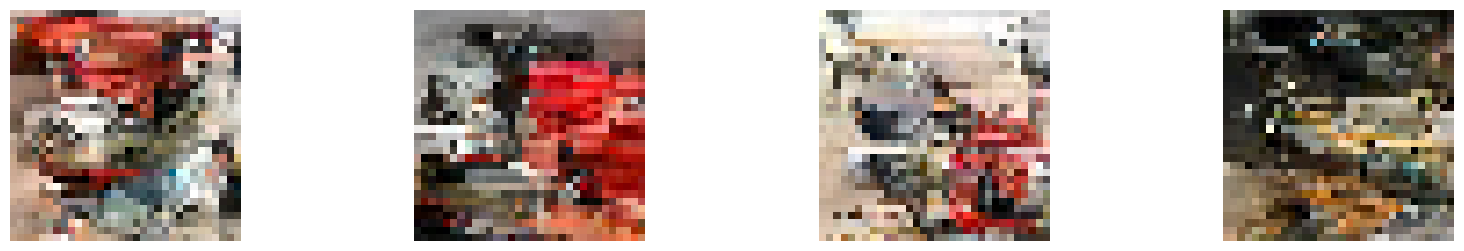

692/692 [==============================] - 575s 829ms/step - loss: 7613.6313
Epoch 15/25
692/692 [==============================] - ETA: 0s - loss: 7584.6475
Saved to ./output_pixelcnn/generated_img_014.png


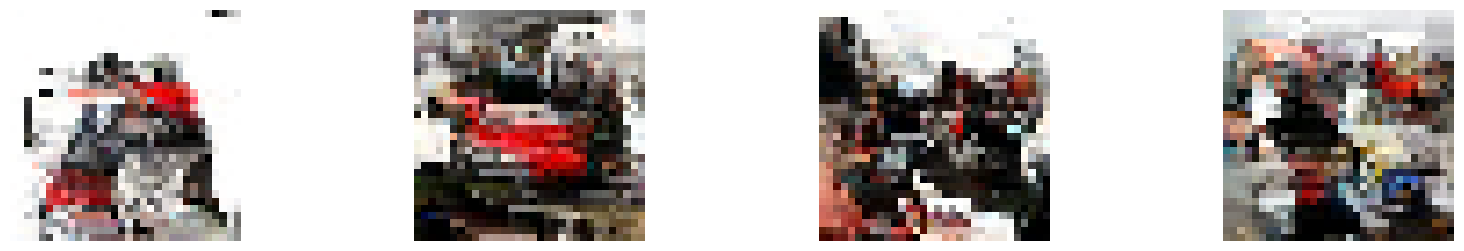

692/692 [==============================] - 574s 828ms/step - loss: 7584.6475
Epoch 16/25
692/692 [==============================] - ETA: 0s - loss: 7539.1670
Saved to ./output_pixelcnn/generated_img_015.png


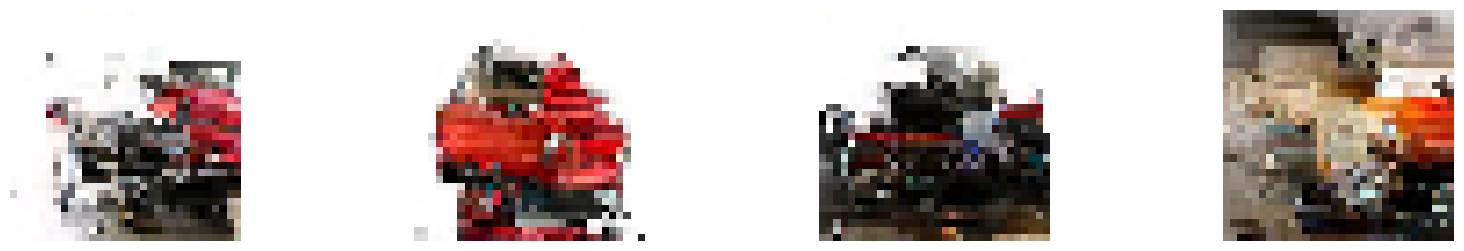

692/692 [==============================] - 571s 825ms/step - loss: 7539.1670
Epoch 17/25
692/692 [==============================] - ETA: 0s - loss: 7511.4229
Saved to ./output_pixelcnn/generated_img_016.png


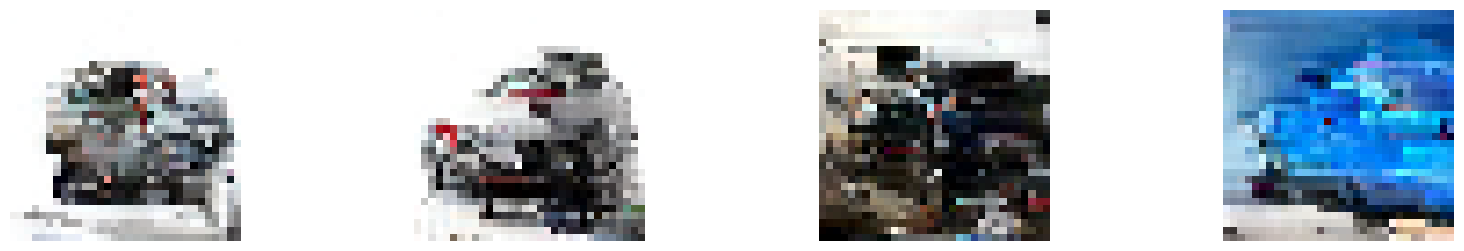

692/692 [==============================] - 576s 832ms/step - loss: 7511.4229
Epoch 18/25
692/692 [==============================] - ETA: 0s - loss: 7547.6792
Saved to ./output_pixelcnn/generated_img_017.png


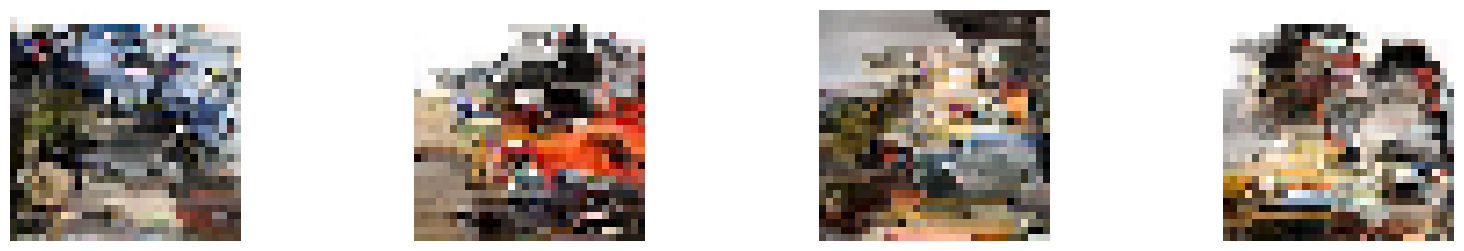

692/692 [==============================] - 575s 828ms/step - loss: 7547.6792
Epoch 19/25
692/692 [==============================] - ETA: 0s - loss: 7494.7334
Saved to ./output_pixelcnn/generated_img_018.png


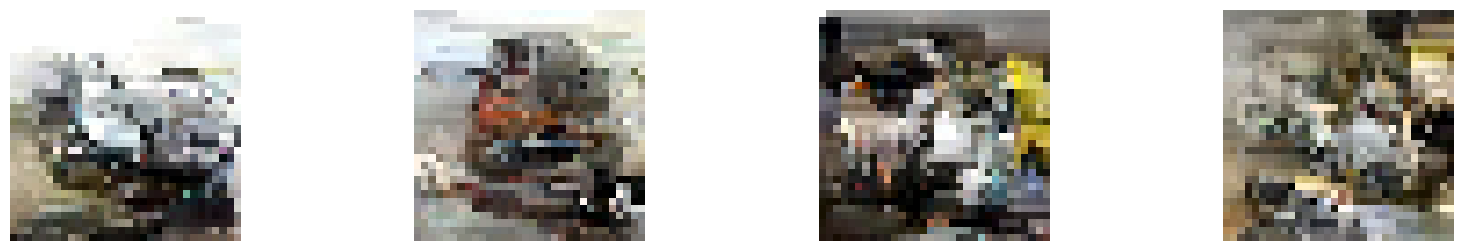

692/692 [==============================] - 572s 826ms/step - loss: 7494.7334
Epoch 20/25
692/692 [==============================] - ETA: 0s - loss: 7447.9175
Saved to ./output_pixelcnn/generated_img_019.png


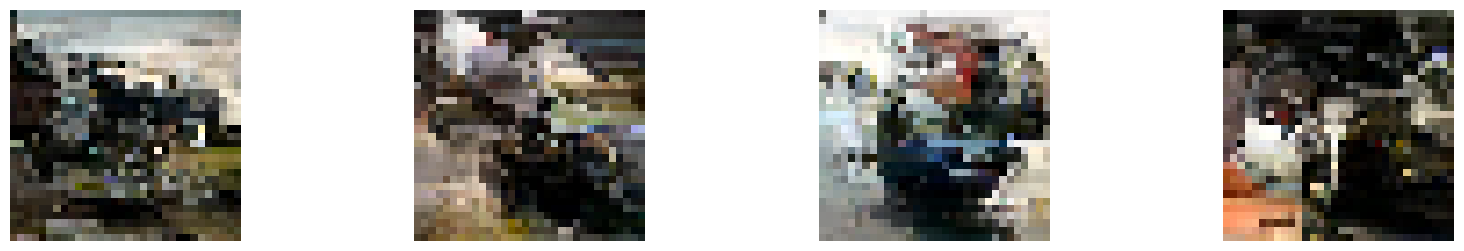

692/692 [==============================] - 574s 828ms/step - loss: 7447.9175
Epoch 21/25
692/692 [==============================] - ETA: 0s - loss: 7447.0186
Saved to ./output_pixelcnn/generated_img_020.png


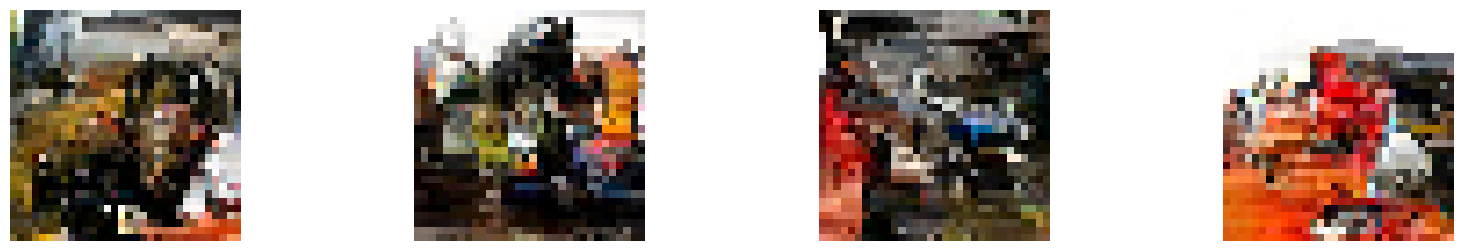

692/692 [==============================] - 572s 826ms/step - loss: 7447.0186
Epoch 22/25
692/692 [==============================] - ETA: 0s - loss: 7425.0962
Saved to ./output_pixelcnn/generated_img_021.png


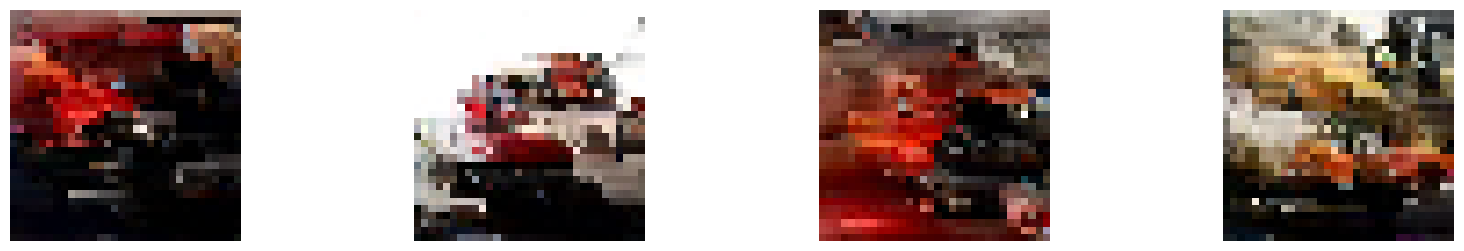

692/692 [==============================] - 569s 821ms/step - loss: 7425.0962
Epoch 23/25
692/692 [==============================] - ETA: 0s - loss: 7455.6719
Saved to ./output_pixelcnn/generated_img_022.png


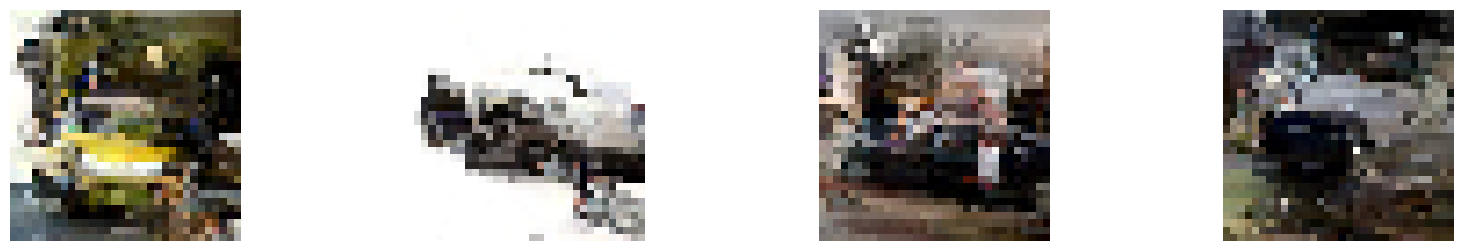

692/692 [==============================] - 569s 820ms/step - loss: 7455.6719
Epoch 24/25
692/692 [==============================] - ETA: 0s - loss: 7441.4683

In [ ]:
pixelcnn.fit(
    train_data,
    batch_size=128,
    epochs=25,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

In [ ]:
generated_images = img_generator_callback.generate()
display(generated_images, n=img_generator_callback.num_img)

In [ ]:
display(sample_batch(train_data), n=4)